In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func, compartment_restrainer
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import time
import os
import seaborn as sns

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Using TensorFlow backend.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


In [2]:
# Make up some populations (take as known)
M = 3
np.random.seed(0)
population = np.maximum(1000, np.round(np.random.normal(loc=100000, scale=25000, size=(M,)), 0))
area = np.maximum(250, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
print(area, population)
population_fraction = population/np.sum(population)
print (np.sum(population))

[4241. 3868. 1023.] [144101. 110004. 124468.]
378573.0


## Reference trajectory

In [3]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 7, 3)
tmat.add_transition('A', 'I', 5, 3)
tmat.add_transition('I', 'R', 14, 4)

In [4]:
infect_fxn = maxentep.contact_infection_func(infections_compartments)
timesteps = 250
model = maxentep.MetaModel(infect_fxn, timesteps, populations=population_fraction)

In [5]:
# starting fractions probabilities
start = np.zeros((M,C)) #anywhere
# start[0,0] = 0.1
# start[0,3] = 0.01
# start[0,1] = 0.2
start[0,2] = 0.02
start[0,1] = 0.05
np.random.seed(0)
# R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = np.array([[1000, 400, 10],
             [0, 300, 300],
             [300, 300, 1000]])
R_norm = R / np.sum(R, axis=1)
print (R_norm)
print(tmat.value)

[[0.70921986 0.66666667 0.00625   ]
 [0.         0.5        0.1875    ]
 [0.21276596 0.5        0.625     ]]
[[0.85714286 0.14285714 0.         0.        ]
 [0.         0.8        0.2        0.        ]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]


In [6]:
ref_traj = model(R_norm, tmat.value, start, 0.025)[0]
print (ref_traj.shape)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(250, 3, 5)


In [7]:
# def f(beta, ntot, ninf):
#     p = 1 - tf.math.exp(tf.math.log(1 - tf.reshape(beta, (-1, 1)))
#                           * tf.reduce_sum((ninf) / ntot[:, :, tf.newaxis], axis=2))
#     return p
# p = []
# for i in np.linspace(0,1,10):
#     ninf = np.zeros((1,M), dtype = np.float32)
#     ninf[0,0] = i
#     print (f(0.01, np.ones((1,M), dtype = np.float32),ninf))
#     p.append(f(0.01, np.ones((1,M), dtype = np.float32),ninf))


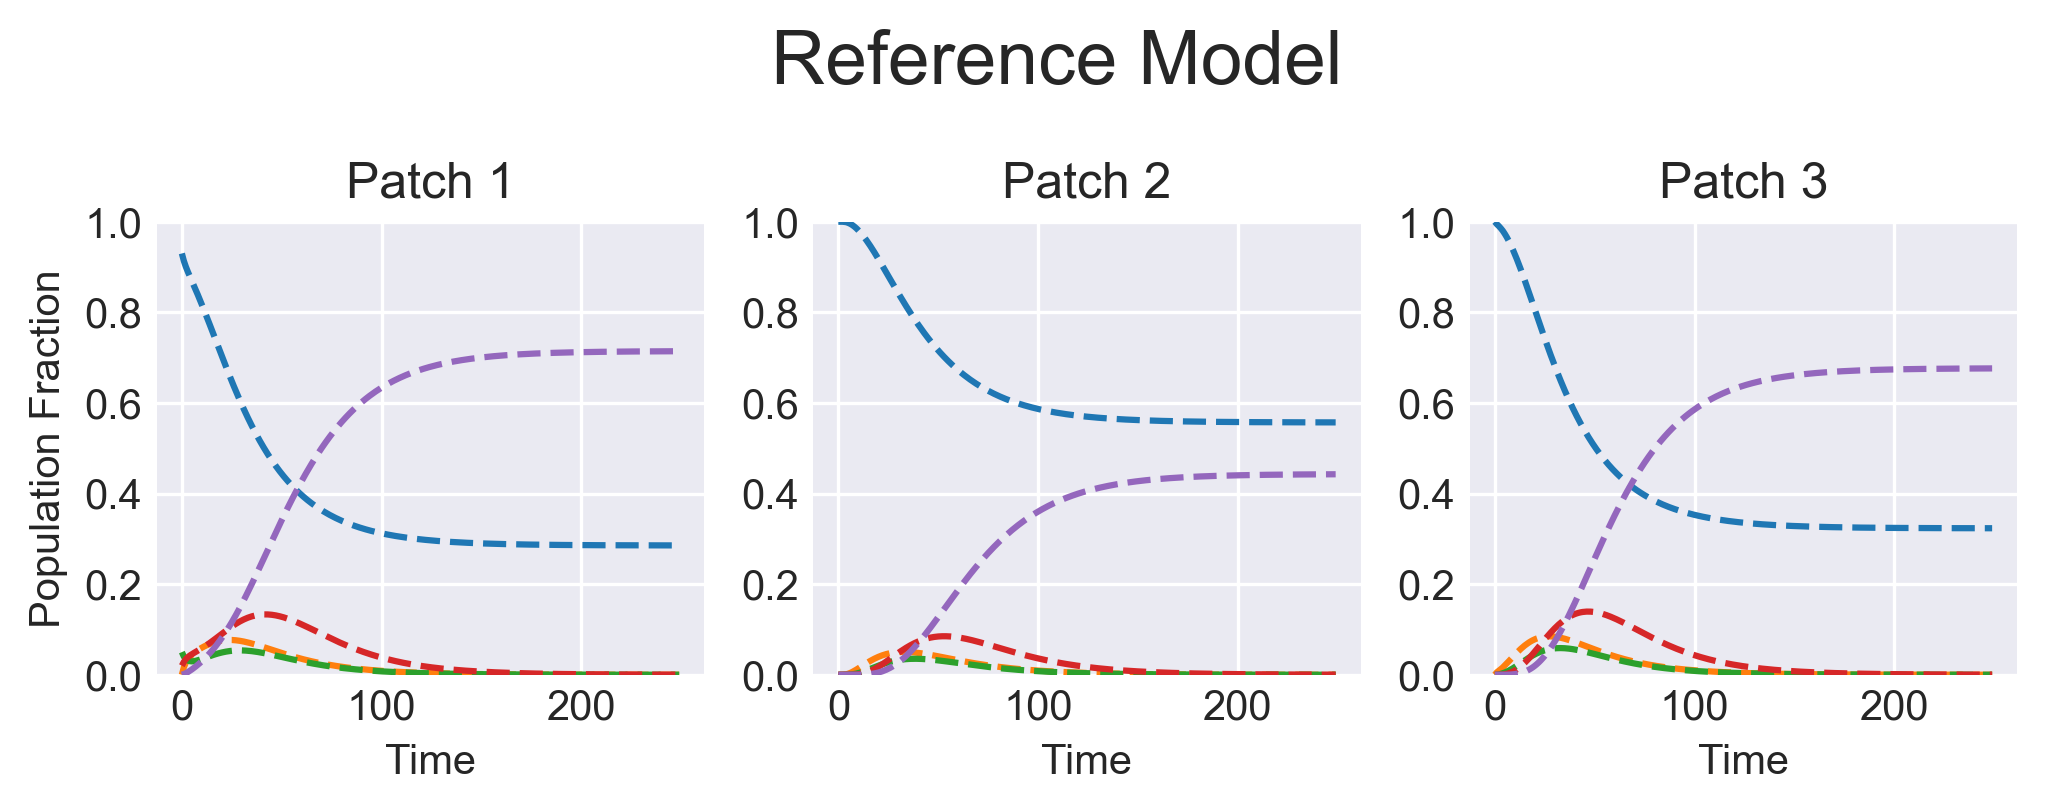

tf.Tensor(
[[9.3000001e-01 0.0000000e+00 5.0000001e-02 2.0000000e-02 0.0000000e+00]
 [9.1351068e-01 1.6489347e-02 4.0000003e-02 2.8571427e-02 1.4285714e-03]
 [9.0063554e-01 2.7008828e-02 3.4355622e-02 3.4530610e-02 3.4693875e-03]
 ...
 [2.8569031e-01 9.8567813e-05 8.5043037e-05 4.6003459e-04 7.1366608e-01]
 [2.8567964e-01 9.5171024e-05 8.2115548e-05 4.4418356e-04 7.1369892e-01]
 [2.8566933e-01 9.1897942e-05 7.9288300e-05 4.2887928e-04 7.1373063e-01]], shape=(230, 5), dtype=float32)
tf.Tensor(
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 ...
 [5.57283759e-01 1.12182679e-04 9.67724918e-05 5.21353155e-04
  4.41985935e-01]
 [5.57271600e-01 1.08315973e-04 9.34440905e-05 5.03468153e-04
  4.42023188e-01]
 [5.57259798e-01 1.04594495e-04 9.02289903e-05 4.86194942e-04
  4.42059159e-01]], shape=(230, 5),

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Reference Model', y = 1.2, fontsize = 18)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()
print (ref_traj[:-20:,0,:])
print (ref_traj[:-20:,1,:])
print (ref_traj[:-20:,1,:] == ref_traj[:-20:,0,:])
# print (tf.reduce_sum(ref_traj[:,0,:],axis=-1))

## Sample SEAIR Trajectories

Creating a set of trajectories.

In [9]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'A', 7, 1)
tmat.add_transition('A', 'I', 2, 4)
tmat.add_transition('I', 'R', 14, 3)
full_compartments = ['S'] + compartments

In [32]:
# starting fractions probabilities
start_logits = np.zeros((M)) #anywhere
start_logits[0]=np.log(0.9)
hyper_pram = maxentep.ParameterHypers()
hyper_pram.beta_var = 0.9
hyper_pram.beta_start = 0.01
hyper_pram.beta_high = 0.15
hyper_pram.beta_low = 0.001
hyper_pram.start_mean = 0.001
hyper_pram.start_high = 0.4
hyper_pram.start_var = 0.5
# hyper_pram.R_var = 0.9
# hyper_pram.start_high = 0.01
# R_sample_norm = np.array([[0.1, 0.8, 0.1],
#              [0.05, 0.8, 0.15],
#              [0.01, 0.12, 0.87]])
# # R_sample_norm = R_sample / np.sum(R_sample, axis=1)

In [47]:
param_model = maxentep.MetaParameterJoint(start_logits, R_norm, tmat, name='unbiased model', hypers = hyper_pram)

In [48]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 2048
batches = 4
batch_size = N*batches
outs = []
timesteps = 250
# infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
model = maxentep.MetaModel(infect_fxn, timesteps, populations=population_fraction)
for b in tqdm.tqdm(range(batches)):
    psample = param_model.sample(N)
    outs.append(model(*psample))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:10<00:00,  2.65s/it]

(8192, 250, 3, 5)


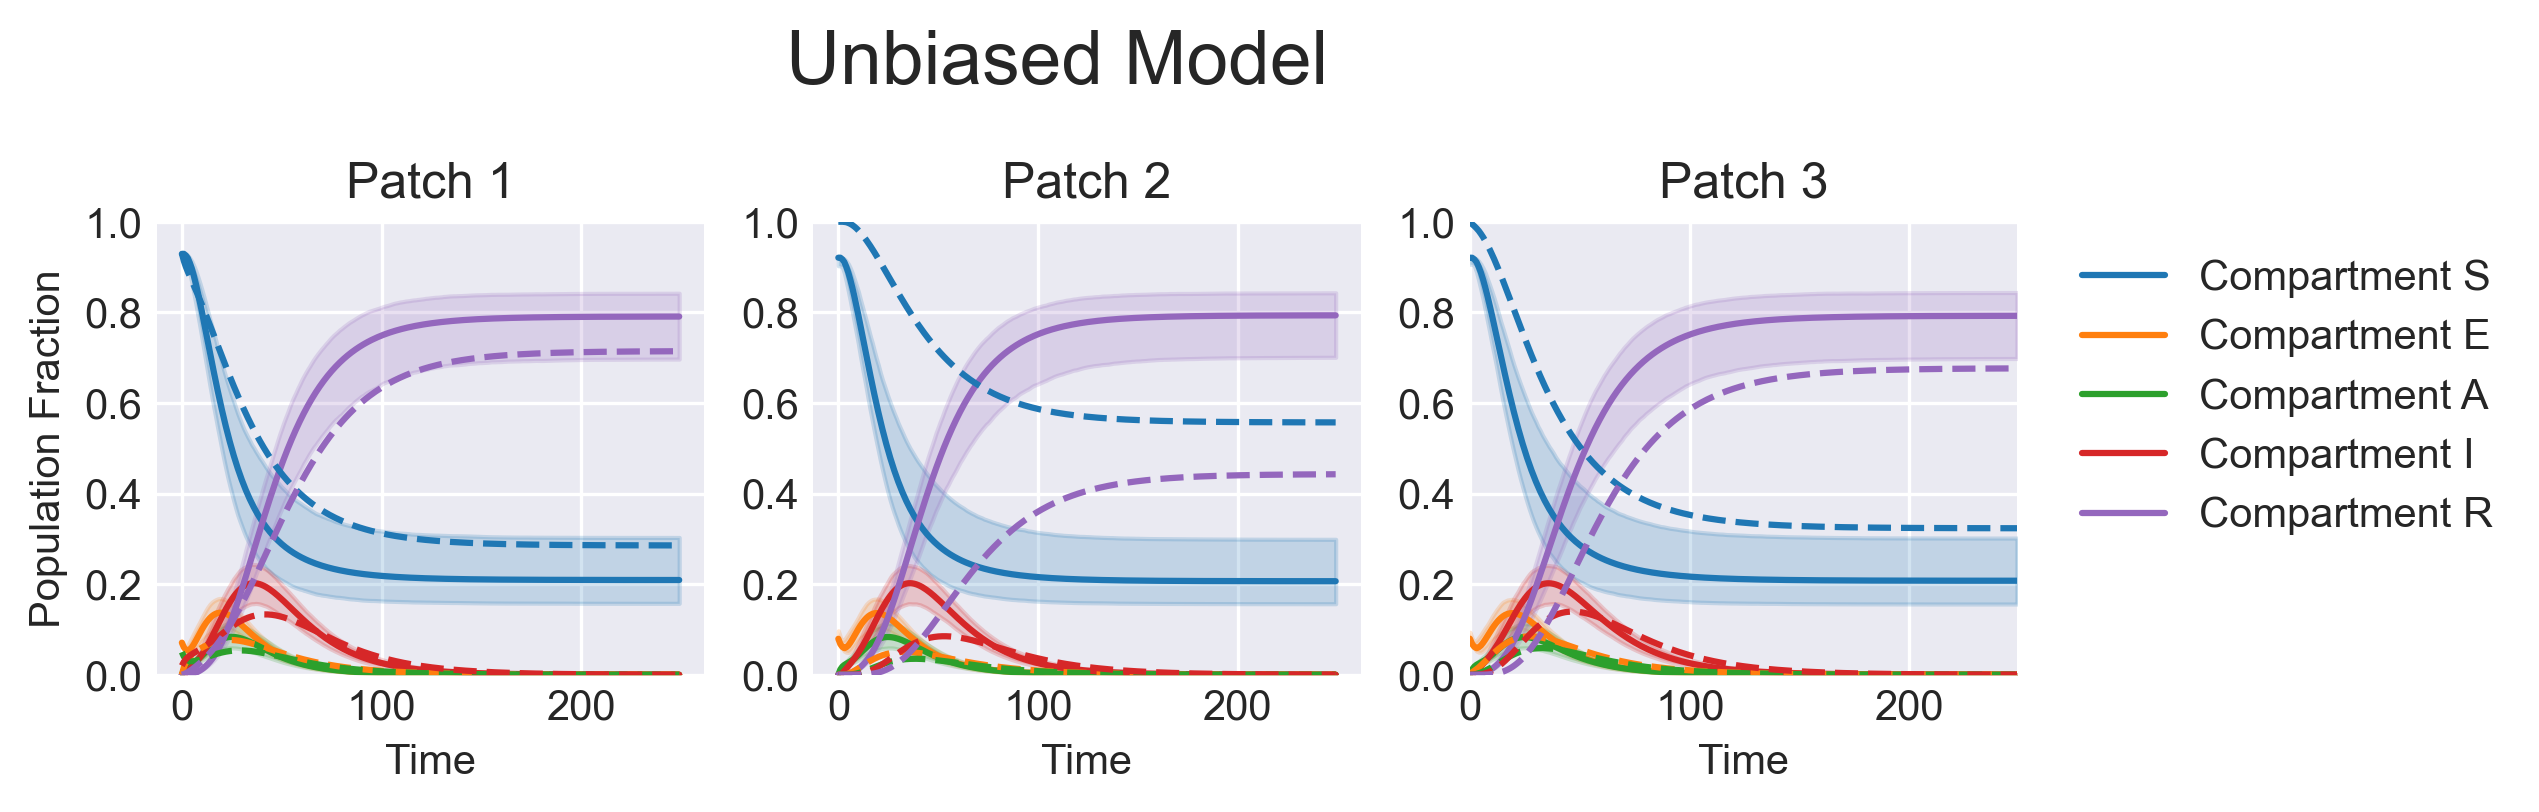

In [49]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Unbiased Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# maxentep.traj_quantile(revised_trajs_0, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
# maxentep.traj_quantile(revised_trajs_1, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
# maxentep.traj_quantile(revised_trajs_2, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()

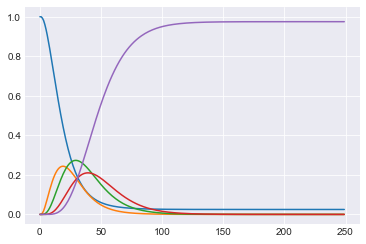

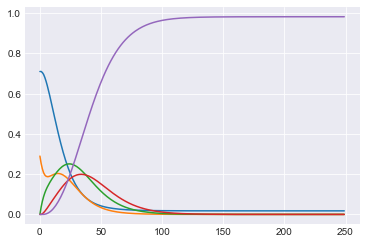

In [74]:
plt.plot(trajs[1234,:,1,:])
plt.show()
plt.plot(trajs[1234,:,2,:])
# print (trajs[:-20:,1,:] == trajs[:-20:,0,:])
# fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
# # fig.suptitle('Unbiased Model', y = 1.2, fontsize = 18)
# axs[0].plot(trajs[0,:,0,:])
# axs[1].plot(trajs[100,:,1,:])
# # maxentep.traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# # maxentep.traj_quantile(revised_trajs_0, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# # maxentep.traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
# # maxentep.traj_quantile(revised_trajs_1, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# # maxentep.traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
# # maxentep.traj_quantile(revised_trajs_2, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
# for i in range (M):
#     plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
#     axs[i].plot(ref_traj[:,i],linestyle='--')
# axs[0].set_ylabel('Population Fraction')
# plt.show()

## Make restraints from reference trajectory

In [51]:
npoints = 10
# prior = maxentep.EmptyPrior()
prior = maxentep.Laplace(0.01)
restrained_compartments = [0, 3, 4] #(infected patch)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
number_of_restrained_compartments = len(restrained_compartments) 
# restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
restrained_patches = np.array([0])
print ('Patches restrained:', restrained_patches)
print ('Total number of restraints: ', npoints*number_of_restrained_compartments*len(restrained_patches))
print ('Compartments restrained: ', restrained_compartments_names)
restraints, plot_fxns_list, restraints_dict = maxentep.compartment_restrainer(restrained_patches, restrained_compartments, npoints, ref_traj, prior, noise=0, start_time= 0, end_time = 100)

Patches restrained: [0]
Total number of restraints:  30
Compartments restrained:  ['S', 'I', 'R']
Restraints are set on this time range: [0, 100]
17 0.7380277 0.7380276918411255
80 0.34004194 0.3400419354438782
59 0.40076563 0.40076562762260437
73 0.35550547 0.35550546646118164
94 0.31863117 0.3186311721801758
31 0.58688277 0.5868827700614929
52 0.43315676 0.4331567585468292
3 0.891638 0.8916379809379578
10 0.8168713 0.8168712854385376
24 0.6590217 0.6590216755867004
10 0.058650013 0.05865001305937767
52 0.12503009 0.12503008544445038
45 0.13207568 0.13207568228244781
3 0.03684497 0.03684496879577637
38 0.13152371 0.1315237134695053
80 0.06942841 0.06942840665578842
31 0.121692084 0.12169208377599716
66 0.098544255 0.09854425489902496
73 0.083592534 0.08359253406524658
17 0.08018887 0.08018887042999268
24 0.10907684 0.1090768426656723
45 0.29452634 0.2945263385772705
94 0.61551464 0.6155146360397339
3 0.0066124243 0.006612424273043871
59 0.41940045 0.4194004535675049
17 0.06397509 0.06

In [52]:
print (restraints_dict)

{'npoints': 10, 'restrained_patches': [0], 'restrained_compartments': [0, 3, 4]}


## Visualizing Restraints

Text(0, 0.5, 'Population Fraction')

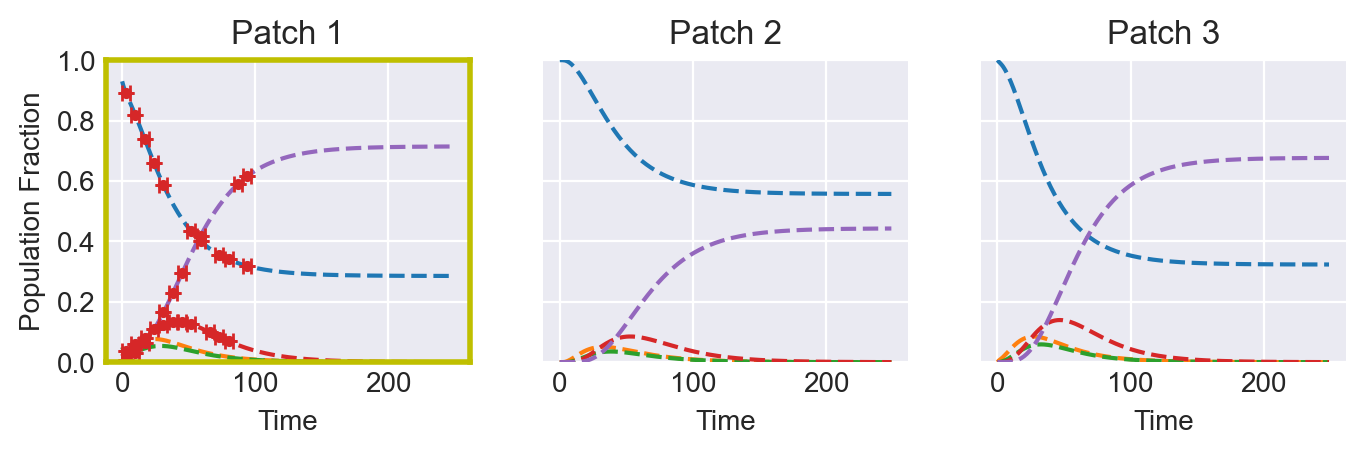

In [53]:
fig, axs = plt.subplots(nrows=1, ncols=M, sharex=True,
                           sharey=True, figsize=(8,2), dpi =200)
for i in range(M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1),ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')


In [54]:
me_model = maxentep.MaxentModel(restraints, ref_traj=ref_traj[np.newaxis,:,:,:], trajs=trajs, population_fraction=population_fraction)
me_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')
print (ref_traj[np.newaxis,:,:,:].shape)
print (population_fraction.shape)
print (trajs.shape)

(1, 250, 3, 5)
(3,)
(8192, 250, 3, 5)


In [55]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self. i = 0
    def on_epoch_begin(self, epoch, logs=None):
        self.i += 1
        return self.i

In [56]:
me_history = me_model.fit(trajs, batch_size=batch_size,epochs=1000, callbacks=[CustomCallback()])

Epoch 1/1000
1/1 [==============================] - 0s 999us/step - loss: 0.0205 - ref-error-metric: 1.5733 - ref-error: 1.5733 - weight-entropy: 8.9106
Epoch 2/1000
1/1 [==============================] - 0s 997us/step - loss: 0.0197 - ref-error-metric: 1.5828 - ref-error: 1.5828 - weight-entropy: 8.9211
Epoch 3/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0189 - ref-error-metric: 1.5926 - ref-error: 1.5926 - weight-entropy: 8.9311
Epoch 4/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0180 - ref-error-metric: 1.5806 - ref-error: 1.5806 - weight-entropy: 8.9408
Epoch 5/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0172 - ref-error-metric: 1.5790 - ref-error: 1.5790 - weight-entropy: 8.9501
Epoch 6/1000
1/1 [==============================] - 0s 998us/step - loss: 0.0163 - ref-error-metric: 1.5909 - ref-error: 1.5909 - weight-entropy: 8.9589
Epoch 7/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.0154 - ref-err

1/1 [==============================] - 0s 998us/step - loss: 5.8337e-04 - ref-error-metric: 1.5892 - ref-error: 1.5892 - weight-entropy: 8.8465
Epoch 54/1000
1/1 [==============================] - 0s 999us/step - loss: 5.6652e-04 - ref-error-metric: 1.6079 - ref-error: 1.6079 - weight-entropy: 8.8523
Epoch 55/1000
1/1 [==============================] - 0s 985us/step - loss: 5.5599e-04 - ref-error-metric: 1.5791 - ref-error: 1.5791 - weight-entropy: 8.8578
Epoch 56/1000
1/1 [==============================] - 0s 997us/step - loss: 5.5095e-04 - ref-error-metric: 1.5822 - ref-error: 1.5822 - weight-entropy: 8.8628
Epoch 57/1000
1/1 [==============================] - 0s 2ms/step - loss: 5.5036e-04 - ref-error-metric: 1.5641 - ref-error: 1.5641 - weight-entropy: 8.8673
Epoch 58/1000
1/1 [==============================] - 0s 997us/step - loss: 5.5310e-04 - ref-error-metric: 1.5610 - ref-error: 1.5610 - weight-entropy: 8.8713
Epoch 59/1000
1/1 [==============================] - 0s 997us/step -

1/1 [==============================] - 0s 0s/step - loss: 5.4085e-04 - ref-error-metric: 1.5871 - ref-error: 1.5871 - weight-entropy: 8.8682
Epoch 106/1000
1/1 [==============================] - 0s 997us/step - loss: 5.4071e-04 - ref-error-metric: 1.5579 - ref-error: 1.5579 - weight-entropy: 8.8685
Epoch 107/1000
1/1 [==============================] - 0s 999us/step - loss: 5.4055e-04 - ref-error-metric: 1.5840 - ref-error: 1.5840 - weight-entropy: 8.8687
Epoch 108/1000
1/1 [==============================] - 0s 998us/step - loss: 5.4036e-04 - ref-error-metric: 1.5684 - ref-error: 1.5684 - weight-entropy: 8.8688
Epoch 109/1000
1/1 [==============================] - 0s 997us/step - loss: 5.4015e-04 - ref-error-metric: 1.5721 - ref-error: 1.5721 - weight-entropy: 8.8689
Epoch 110/1000
1/1 [==============================] - 0s 0s/step - loss: 5.3991e-04 - ref-error-metric: 1.6019 - ref-error: 1.6019 - weight-entropy: 8.8689
Epoch 111/1000
1/1 [==============================] - 0s 2ms/step -

1/1 [==============================] - 0s 998us/step - loss: 5.2835e-04 - ref-error-metric: 1.5846 - ref-error: 1.5846 - weight-entropy: 8.8677
Epoch 157/1000
1/1 [==============================] - 0s 998us/step - loss: 5.2810e-04 - ref-error-metric: 1.6019 - ref-error: 1.6019 - weight-entropy: 8.8677
Epoch 158/1000
1/1 [==============================] - 0s 997us/step - loss: 5.2785e-04 - ref-error-metric: 1.5556 - ref-error: 1.5556 - weight-entropy: 8.8677
Epoch 159/1000
1/1 [==============================] - 0s 999us/step - loss: 5.2761e-04 - ref-error-metric: 1.5821 - ref-error: 1.5821 - weight-entropy: 8.8677
Epoch 160/1000
1/1 [==============================] - 0s 997us/step - loss: 5.2736e-04 - ref-error-metric: 1.5935 - ref-error: 1.5935 - weight-entropy: 8.8677
Epoch 161/1000
1/1 [==============================] - 0s 999us/step - loss: 5.2711e-04 - ref-error-metric: 1.5811 - ref-error: 1.5811 - weight-entropy: 8.8677
Epoch 162/1000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 2ms/step - loss: 5.1560e-04 - ref-error-metric: 1.6004 - ref-error: 1.6004 - weight-entropy: 8.8683
Epoch 208/1000
1/1 [==============================] - 0s 997us/step - loss: 5.1535e-04 - ref-error-metric: 1.5957 - ref-error: 1.5957 - weight-entropy: 8.8684
Epoch 209/1000
1/1 [==============================] - 0s 3ms/step - loss: 5.1510e-04 - ref-error-metric: 1.5916 - ref-error: 1.5916 - weight-entropy: 8.8684
Epoch 210/1000
1/1 [==============================] - 0s 997us/step - loss: 5.1485e-04 - ref-error-metric: 1.5733 - ref-error: 1.5733 - weight-entropy: 8.8684
Epoch 211/1000
1/1 [==============================] - 0s 2ms/step - loss: 5.1460e-04 - ref-error-metric: 1.5642 - ref-error: 1.5642 - weight-entropy: 8.8684
Epoch 212/1000
1/1 [==============================] - 0s 2ms/step - loss: 5.1436e-04 - ref-error-metric: 1.5910 - ref-error: 1.5910 - weight-entropy: 8.8684
Epoch 213/1000
1/1 [==============================] - 0s 997us/step -

1/1 [==============================] - 0s 998us/step - loss: 5.0325e-04 - ref-error-metric: 1.5737 - ref-error: 1.5737 - weight-entropy: 8.8686
Epoch 259/1000
1/1 [==============================] - 0s 2ms/step - loss: 5.0302e-04 - ref-error-metric: 1.5855 - ref-error: 1.5855 - weight-entropy: 8.8686
Epoch 260/1000
1/1 [==============================] - 0s 997us/step - loss: 5.0279e-04 - ref-error-metric: 1.5707 - ref-error: 1.5707 - weight-entropy: 8.8686
Epoch 261/1000
1/1 [==============================] - 0s 996us/step - loss: 5.0255e-04 - ref-error-metric: 1.5612 - ref-error: 1.5612 - weight-entropy: 8.8686
Epoch 262/1000
1/1 [==============================] - 0s 997us/step - loss: 5.0232e-04 - ref-error-metric: 1.5818 - ref-error: 1.5818 - weight-entropy: 8.8686
Epoch 263/1000
1/1 [==============================] - 0s 997us/step - loss: 5.0209e-04 - ref-error-metric: 1.5743 - ref-error: 1.5743 - weight-entropy: 8.8686
Epoch 264/1000
1/1 [==============================] - 0s 2ms/st

1/1 [==============================] - 0s 0s/step - loss: 4.9186e-04 - ref-error-metric: 1.5870 - ref-error: 1.5870 - weight-entropy: 8.8683
Epoch 310/1000
1/1 [==============================] - 0s 998us/step - loss: 4.9165e-04 - ref-error-metric: 1.6084 - ref-error: 1.6084 - weight-entropy: 8.8683
Epoch 311/1000
1/1 [==============================] - 0s 997us/step - loss: 4.9144e-04 - ref-error-metric: 1.5766 - ref-error: 1.5766 - weight-entropy: 8.8682
Epoch 312/1000
1/1 [==============================] - 0s 997us/step - loss: 4.9123e-04 - ref-error-metric: 1.5746 - ref-error: 1.5746 - weight-entropy: 8.8682
Epoch 313/1000
1/1 [==============================] - 0s 997us/step - loss: 4.9102e-04 - ref-error-metric: 1.5783 - ref-error: 1.5783 - weight-entropy: 8.8682
Epoch 314/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.9081e-04 - ref-error-metric: 1.5936 - ref-error: 1.5936 - weight-entropy: 8.8682
Epoch 315/1000
1/1 [==============================] - 0s 0s/step -

1/1 [==============================] - 0s 998us/step - loss: 4.8157e-04 - ref-error-metric: 1.5722 - ref-error: 1.5722 - weight-entropy: 8.8676
Epoch 361/1000
1/1 [==============================] - 0s 998us/step - loss: 4.8138e-04 - ref-error-metric: 1.5844 - ref-error: 1.5844 - weight-entropy: 8.8675
Epoch 362/1000
1/1 [==============================] - 0s 996us/step - loss: 4.8119e-04 - ref-error-metric: 1.5306 - ref-error: 1.5306 - weight-entropy: 8.8675
Epoch 363/1000
1/1 [==============================] - 0s 996us/step - loss: 4.8099e-04 - ref-error-metric: 1.5809 - ref-error: 1.5809 - weight-entropy: 8.8675
Epoch 364/1000
1/1 [==============================] - 0s 997us/step - loss: 4.8080e-04 - ref-error-metric: 1.6072 - ref-error: 1.6072 - weight-entropy: 8.8675
Epoch 365/1000
1/1 [==============================] - 0s 998us/step - loss: 4.8061e-04 - ref-error-metric: 1.5781 - ref-error: 1.5781 - weight-entropy: 8.8675
Epoch 366/1000
1/1 [==============================] - 0s 2ms/

1/1 [==============================] - 0s 0s/step - loss: 4.7220e-04 - ref-error-metric: 1.5821 - ref-error: 1.5821 - weight-entropy: 8.8666
Epoch 412/1000
1/1 [==============================] - 0s 996us/step - loss: 4.7202e-04 - ref-error-metric: 1.6076 - ref-error: 1.6076 - weight-entropy: 8.8666
Epoch 413/1000
1/1 [==============================] - 0s 997us/step - loss: 4.7185e-04 - ref-error-metric: 1.5864 - ref-error: 1.5864 - weight-entropy: 8.8666
Epoch 414/1000
1/1 [==============================] - 0s 997us/step - loss: 4.7167e-04 - ref-error-metric: 1.5846 - ref-error: 1.5846 - weight-entropy: 8.8665
Epoch 415/1000
1/1 [==============================] - 0s 997us/step - loss: 4.7150e-04 - ref-error-metric: 1.6034 - ref-error: 1.6034 - weight-entropy: 8.8665
Epoch 416/1000
1/1 [==============================] - 0s 998us/step - loss: 4.7132e-04 - ref-error-metric: 1.5738 - ref-error: 1.5738 - weight-entropy: 8.8665
Epoch 417/1000
1/1 [==============================] - 0s 998us/s

1/1 [==============================] - 0s 2ms/step - loss: 4.6343e-04 - ref-error-metric: 1.5842 - ref-error: 1.5842 - weight-entropy: 8.8655
Epoch 463/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.6327e-04 - ref-error-metric: 1.5809 - ref-error: 1.5809 - weight-entropy: 8.8655
Epoch 464/1000
1/1 [==============================] - 0s 997us/step - loss: 4.6310e-04 - ref-error-metric: 1.5463 - ref-error: 1.5463 - weight-entropy: 8.8655
Epoch 465/1000
1/1 [==============================] - 0s 999us/step - loss: 4.6293e-04 - ref-error-metric: 1.5928 - ref-error: 1.5928 - weight-entropy: 8.8655
Epoch 466/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.6276e-04 - ref-error-metric: 1.5521 - ref-error: 1.5521 - weight-entropy: 8.8654
Epoch 467/1000
1/1 [==============================] - 0s 998us/step - loss: 4.6259e-04 - ref-error-metric: 1.5652 - ref-error: 1.5652 - weight-entropy: 8.8654
Epoch 468/1000
1/1 [==============================] - 0s 997us/step

1/1 [==============================] - 0s 996us/step - loss: 4.5495e-04 - ref-error-metric: 1.5939 - ref-error: 1.5939 - weight-entropy: 8.8644
Epoch 514/1000
1/1 [==============================] - 0s 998us/step - loss: 4.5478e-04 - ref-error-metric: 1.5769 - ref-error: 1.5769 - weight-entropy: 8.8644
Epoch 515/1000
1/1 [==============================] - 0s 998us/step - loss: 4.5462e-04 - ref-error-metric: 1.5691 - ref-error: 1.5691 - weight-entropy: 8.8644
Epoch 516/1000
1/1 [==============================] - 0s 995us/step - loss: 4.5445e-04 - ref-error-metric: 1.5657 - ref-error: 1.5657 - weight-entropy: 8.8644
Epoch 517/1000
1/1 [==============================] - 0s 997us/step - loss: 4.5429e-04 - ref-error-metric: 1.6003 - ref-error: 1.6003 - weight-entropy: 8.8643
Epoch 518/1000
1/1 [==============================] - 0s 997us/step - loss: 4.5412e-04 - ref-error-metric: 1.5748 - ref-error: 1.5748 - weight-entropy: 8.8643
Epoch 519/1000
1/1 [==============================] - 0s 999u

1/1 [==============================] - 0s 998us/step - loss: 4.4653e-04 - ref-error-metric: 1.5890 - ref-error: 1.5890 - weight-entropy: 8.8633
Epoch 565/1000
1/1 [==============================] - 0s 989us/step - loss: 4.4636e-04 - ref-error-metric: 1.5642 - ref-error: 1.5642 - weight-entropy: 8.8633
Epoch 566/1000
1/1 [==============================] - 0s 998us/step - loss: 4.4619e-04 - ref-error-metric: 1.5745 - ref-error: 1.5745 - weight-entropy: 8.8633
Epoch 567/1000
1/1 [==============================] - 0s 997us/step - loss: 4.4603e-04 - ref-error-metric: 1.5657 - ref-error: 1.5657 - weight-entropy: 8.8632
Epoch 568/1000
1/1 [==============================] - 0s 997us/step - loss: 4.4586e-04 - ref-error-metric: 1.5927 - ref-error: 1.5927 - weight-entropy: 8.8632
Epoch 569/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.4570e-04 - ref-error-metric: 1.6031 - ref-error: 1.6031 - weight-entropy: 8.8632
Epoch 570/1000
1/1 [==============================] - 0s 5ms/st

1/1 [==============================] - 0s 998us/step - loss: 4.3804e-04 - ref-error-metric: 1.5843 - ref-error: 1.5843 - weight-entropy: 8.8621
Epoch 616/1000
1/1 [==============================] - 0s 998us/step - loss: 4.3788e-04 - ref-error-metric: 1.5624 - ref-error: 1.5624 - weight-entropy: 8.8621
Epoch 617/1000
1/1 [==============================] - 0s 998us/step - loss: 4.3771e-04 - ref-error-metric: 1.5888 - ref-error: 1.5888 - weight-entropy: 8.8621
Epoch 618/1000
1/1 [==============================] - 0s 997us/step - loss: 4.3754e-04 - ref-error-metric: 1.5571 - ref-error: 1.5571 - weight-entropy: 8.8621
Epoch 619/1000
1/1 [==============================] - 0s 997us/step - loss: 4.3737e-04 - ref-error-metric: 1.6100 - ref-error: 1.6100 - weight-entropy: 8.8620
Epoch 620/1000
1/1 [==============================] - 0s 1ms/step - loss: 4.3721e-04 - ref-error-metric: 1.5802 - ref-error: 1.5802 - weight-entropy: 8.8620
Epoch 621/1000
1/1 [==============================] - 0s 997us/

1/1 [==============================] - 0s 2ms/step - loss: 4.2947e-04 - ref-error-metric: 1.5802 - ref-error: 1.5802 - weight-entropy: 8.8608
Epoch 667/1000
1/1 [==============================] - 0s 998us/step - loss: 4.2930e-04 - ref-error-metric: 1.6021 - ref-error: 1.6021 - weight-entropy: 8.8608
Epoch 668/1000
1/1 [==============================] - 0s 998us/step - loss: 4.2913e-04 - ref-error-metric: 1.5748 - ref-error: 1.5748 - weight-entropy: 8.8608
Epoch 669/1000
1/1 [==============================] - 0s 998us/step - loss: 4.2896e-04 - ref-error-metric: 1.5630 - ref-error: 1.5630 - weight-entropy: 8.8607
Epoch 670/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.2879e-04 - ref-error-metric: 1.5654 - ref-error: 1.5654 - weight-entropy: 8.8607
Epoch 671/1000
1/1 [==============================] - 0s 999us/step - loss: 4.2862e-04 - ref-error-metric: 1.5899 - ref-error: 1.5899 - weight-entropy: 8.8607
Epoch 672/1000
1/1 [==============================] - 0s 998us/st

1/1 [==============================] - 0s 997us/step - loss: 4.2080e-04 - ref-error-metric: 1.5885 - ref-error: 1.5885 - weight-entropy: 8.8593
Epoch 718/1000
1/1 [==============================] - 0s 1000us/step - loss: 4.2063e-04 - ref-error-metric: 1.5619 - ref-error: 1.5619 - weight-entropy: 8.8593
Epoch 719/1000
1/1 [==============================] - 0s 998us/step - loss: 4.2046e-04 - ref-error-metric: 1.5940 - ref-error: 1.5940 - weight-entropy: 8.8592
Epoch 720/1000
1/1 [==============================] - 0s 998us/step - loss: 4.2029e-04 - ref-error-metric: 1.5656 - ref-error: 1.5656 - weight-entropy: 8.8592
Epoch 721/1000
1/1 [==============================] - 0s 999us/step - loss: 4.2012e-04 - ref-error-metric: 1.5726 - ref-error: 1.5726 - weight-entropy: 8.8592
Epoch 722/1000
1/1 [==============================] - 0s 997us/step - loss: 4.1995e-04 - ref-error-metric: 1.5944 - ref-error: 1.5944 - weight-entropy: 8.8591
Epoch 723/1000
1/1 [==============================] - 0s 999

1/1 [==============================] - 0s 998us/step - loss: 4.1208e-04 - ref-error-metric: 1.6026 - ref-error: 1.6026 - weight-entropy: 8.8575
Epoch 769/1000
1/1 [==============================] - 0s 998us/step - loss: 4.1191e-04 - ref-error-metric: 1.5827 - ref-error: 1.5827 - weight-entropy: 8.8575
Epoch 770/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.1174e-04 - ref-error-metric: 1.5587 - ref-error: 1.5587 - weight-entropy: 8.8575
Epoch 771/1000
1/1 [==============================] - 0s 998us/step - loss: 4.1157e-04 - ref-error-metric: 1.5655 - ref-error: 1.5655 - weight-entropy: 8.8574
Epoch 772/1000
1/1 [==============================] - 0s 998us/step - loss: 4.1139e-04 - ref-error-metric: 1.5570 - ref-error: 1.5570 - weight-entropy: 8.8574
Epoch 773/1000
1/1 [==============================] - 0s 997us/step - loss: 4.1122e-04 - ref-error-metric: 1.5980 - ref-error: 1.5980 - weight-entropy: 8.8574
Epoch 774/1000
1/1 [==============================] - 0s 998us/

1/1 [==============================] - 0s 998us/step - loss: 4.0333e-04 - ref-error-metric: 1.5750 - ref-error: 1.5750 - weight-entropy: 8.8555
Epoch 820/1000
1/1 [==============================] - 0s 997us/step - loss: 4.0316e-04 - ref-error-metric: 1.5657 - ref-error: 1.5657 - weight-entropy: 8.8554
Epoch 821/1000
1/1 [==============================] - 0s 999us/step - loss: 4.0298e-04 - ref-error-metric: 1.5672 - ref-error: 1.5672 - weight-entropy: 8.8554
Epoch 822/1000
1/1 [==============================] - 0s 996us/step - loss: 4.0281e-04 - ref-error-metric: 1.5818 - ref-error: 1.5818 - weight-entropy: 8.8554
Epoch 823/1000
1/1 [==============================] - 0s 998us/step - loss: 4.0264e-04 - ref-error-metric: 1.5751 - ref-error: 1.5751 - weight-entropy: 8.8553
Epoch 824/1000
1/1 [==============================] - 0s 2ms/step - loss: 4.0247e-04 - ref-error-metric: 1.5525 - ref-error: 1.5525 - weight-entropy: 8.8553
Epoch 825/1000
1/1 [==============================] - 0s 998us/

1/1 [==============================] - 0s 995us/step - loss: 3.9458e-04 - ref-error-metric: 1.5926 - ref-error: 1.5926 - weight-entropy: 8.8531
Epoch 871/1000
1/1 [==============================] - 0s 998us/step - loss: 3.9441e-04 - ref-error-metric: 1.6016 - ref-error: 1.6016 - weight-entropy: 8.8531
Epoch 872/1000
1/1 [==============================] - 0s 998us/step - loss: 3.9424e-04 - ref-error-metric: 1.5538 - ref-error: 1.5538 - weight-entropy: 8.8530
Epoch 873/1000
1/1 [==============================] - 0s 997us/step - loss: 3.9406e-04 - ref-error-metric: 1.6158 - ref-error: 1.6158 - weight-entropy: 8.8530
Epoch 874/1000
1/1 [==============================] - 0s 999us/step - loss: 3.9389e-04 - ref-error-metric: 1.5636 - ref-error: 1.5636 - weight-entropy: 8.8529
Epoch 875/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.9372e-04 - ref-error-metric: 1.5592 - ref-error: 1.5592 - weight-entropy: 8.8529
Epoch 876/1000
1/1 [==============================] - 0s 998us/

1/1 [==============================] - 0s 2ms/step - loss: 3.8586e-04 - ref-error-metric: 1.5802 - ref-error: 1.5802 - weight-entropy: 8.8504
Epoch 922/1000
1/1 [==============================] - 0s 999us/step - loss: 3.8569e-04 - ref-error-metric: 1.5493 - ref-error: 1.5493 - weight-entropy: 8.8503
Epoch 923/1000
1/1 [==============================] - 0s 2ms/step - loss: 3.8552e-04 - ref-error-metric: 1.5916 - ref-error: 1.5916 - weight-entropy: 8.8503
Epoch 924/1000
1/1 [==============================] - 0s 996us/step - loss: 3.8535e-04 - ref-error-metric: 1.5591 - ref-error: 1.5591 - weight-entropy: 8.8502
Epoch 925/1000
1/1 [==============================] - 0s 999us/step - loss: 3.8518e-04 - ref-error-metric: 1.5523 - ref-error: 1.5523 - weight-entropy: 8.8502
Epoch 926/1000
1/1 [==============================] - 0s 998us/step - loss: 3.8501e-04 - ref-error-metric: 1.5924 - ref-error: 1.5924 - weight-entropy: 8.8501
Epoch 927/1000
1/1 [==============================] - 0s 2ms/step

1/1 [==============================] - 0s 995us/step - loss: 3.7721e-04 - ref-error-metric: 1.6009 - ref-error: 1.6009 - weight-entropy: 8.8473
Epoch 973/1000
1/1 [==============================] - 0s 997us/step - loss: 3.7704e-04 - ref-error-metric: 1.5925 - ref-error: 1.5925 - weight-entropy: 8.8473
Epoch 974/1000
1/1 [==============================] - 0s 997us/step - loss: 3.7687e-04 - ref-error-metric: 1.5996 - ref-error: 1.5996 - weight-entropy: 8.8472
Epoch 975/1000
1/1 [==============================] - 0s 997us/step - loss: 3.7671e-04 - ref-error-metric: 1.5651 - ref-error: 1.5651 - weight-entropy: 8.8471
Epoch 976/1000
1/1 [==============================] - 0s 998us/step - loss: 3.7654e-04 - ref-error-metric: 1.5854 - ref-error: 1.5854 - weight-entropy: 8.8471
Epoch 977/1000
1/1 [==============================] - 0s 997us/step - loss: 3.7637e-04 - ref-error-metric: 1.5826 - ref-error: 1.5826 - weight-entropy: 8.8470
Epoch 978/1000
1/1 [==============================] - 0s 998u

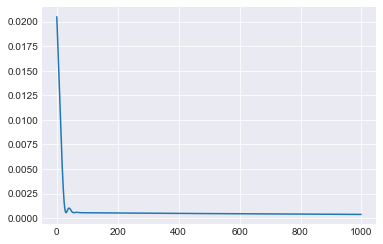

In [57]:
plt.plot(me_history.history['loss'])

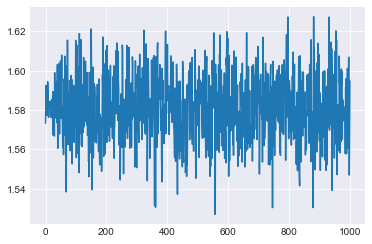

In [58]:
plt.plot(me_history.history['ref-error'])

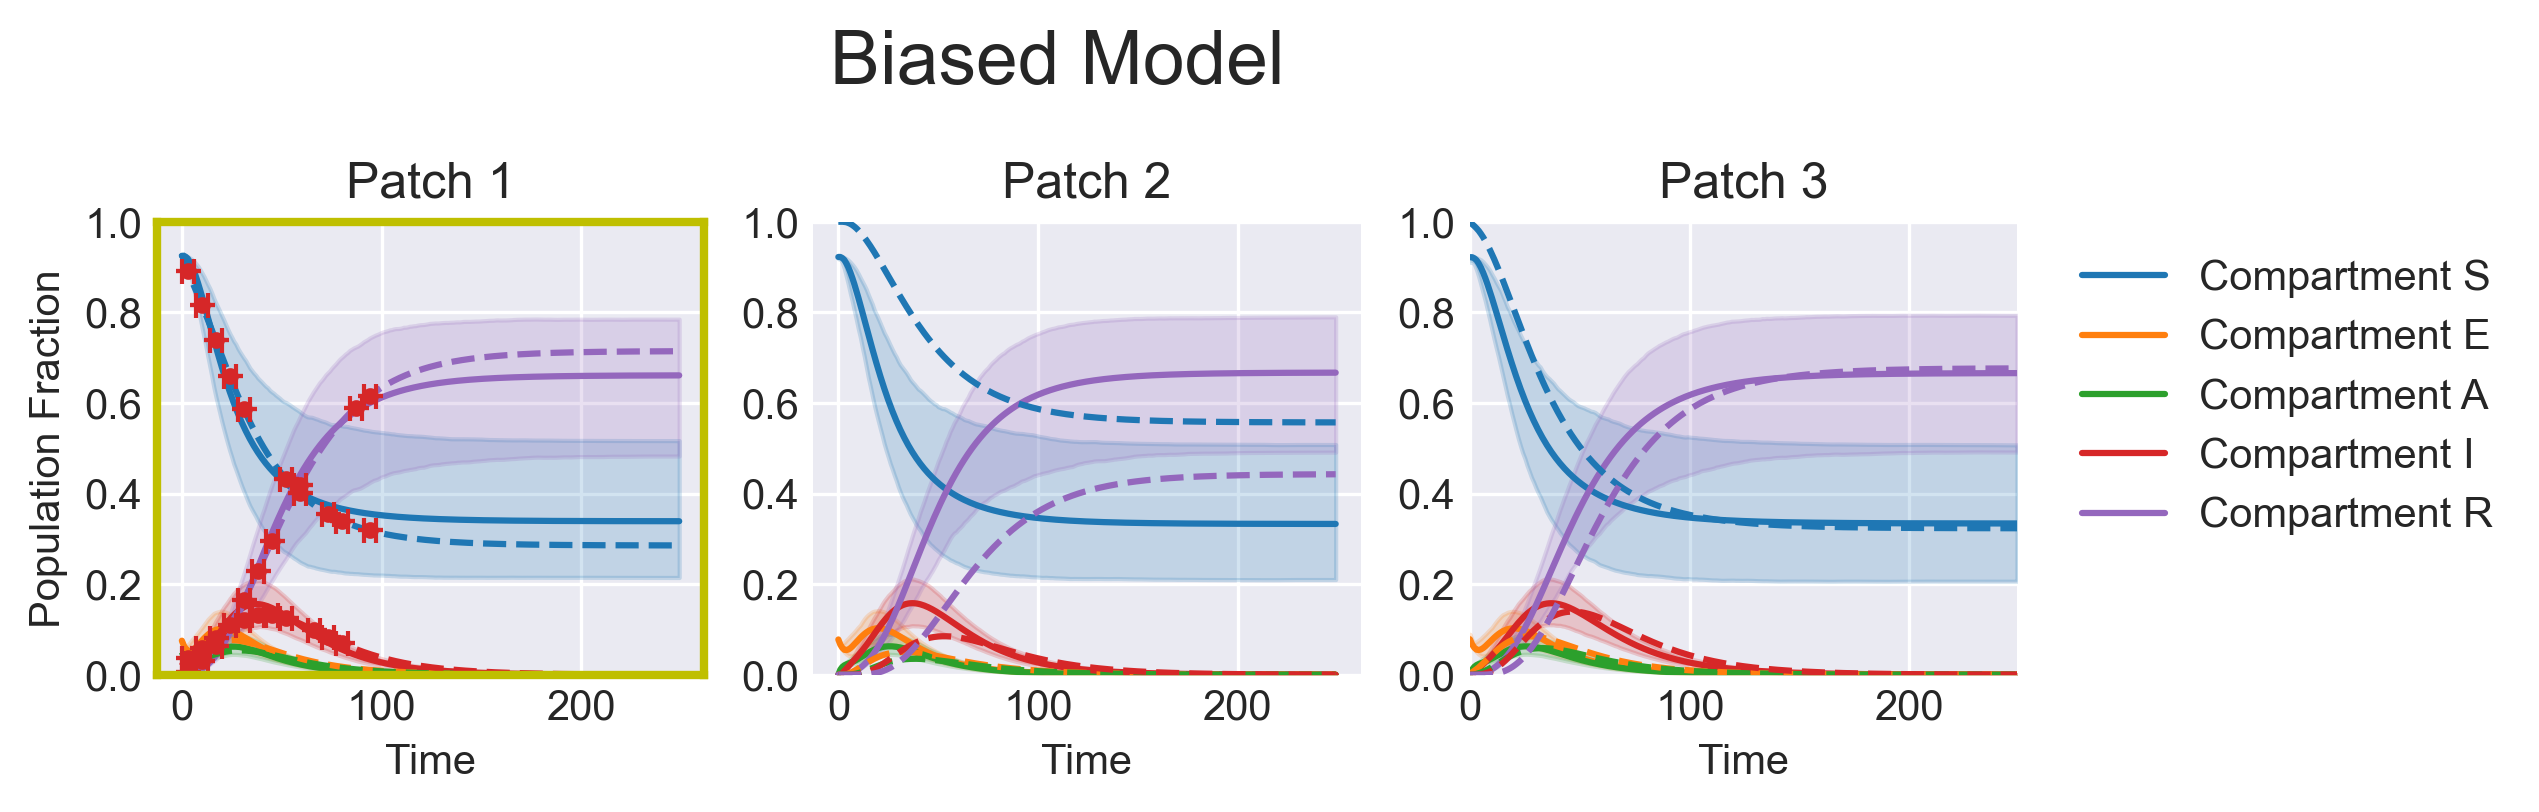

In [59]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Biased Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(me_model.trajs[:,:,0,:], weights=me_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(me_model.trajs[:,:,1,:], weights=me_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(me_model.trajs[:,:,2,:], weights=me_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## Least squares regression

In [60]:
Tmtat = tmat.value
start = np.zeros((M, C))
start[0,0] = 0.05
# start[1,0] = 0.05
beta_start = 0.1
infect = maxentep.ContactInfectionLayer(beta_start, infections_compartments)
# make "agreement" function
def agreement(traj, rs=restraints):
    s = 0
    for r in rs:
        s += r(traj[0])**2
    return s
rmodel = maxentep.TrainableMetaModel(start, R_norm, Tmtat, infect, timesteps, agreement)

In [61]:
rmodel.compile(optimizer=tf.keras.optimizers.Nadam(0.01))
utraj = rmodel.get_traj()
rmodel.fit(timesteps)
regressed_traj = rmodel.get_traj()

250/250 [==============================] - 47s 188ms/step - loss: 0.0241 - output_2_loss: 0.0241


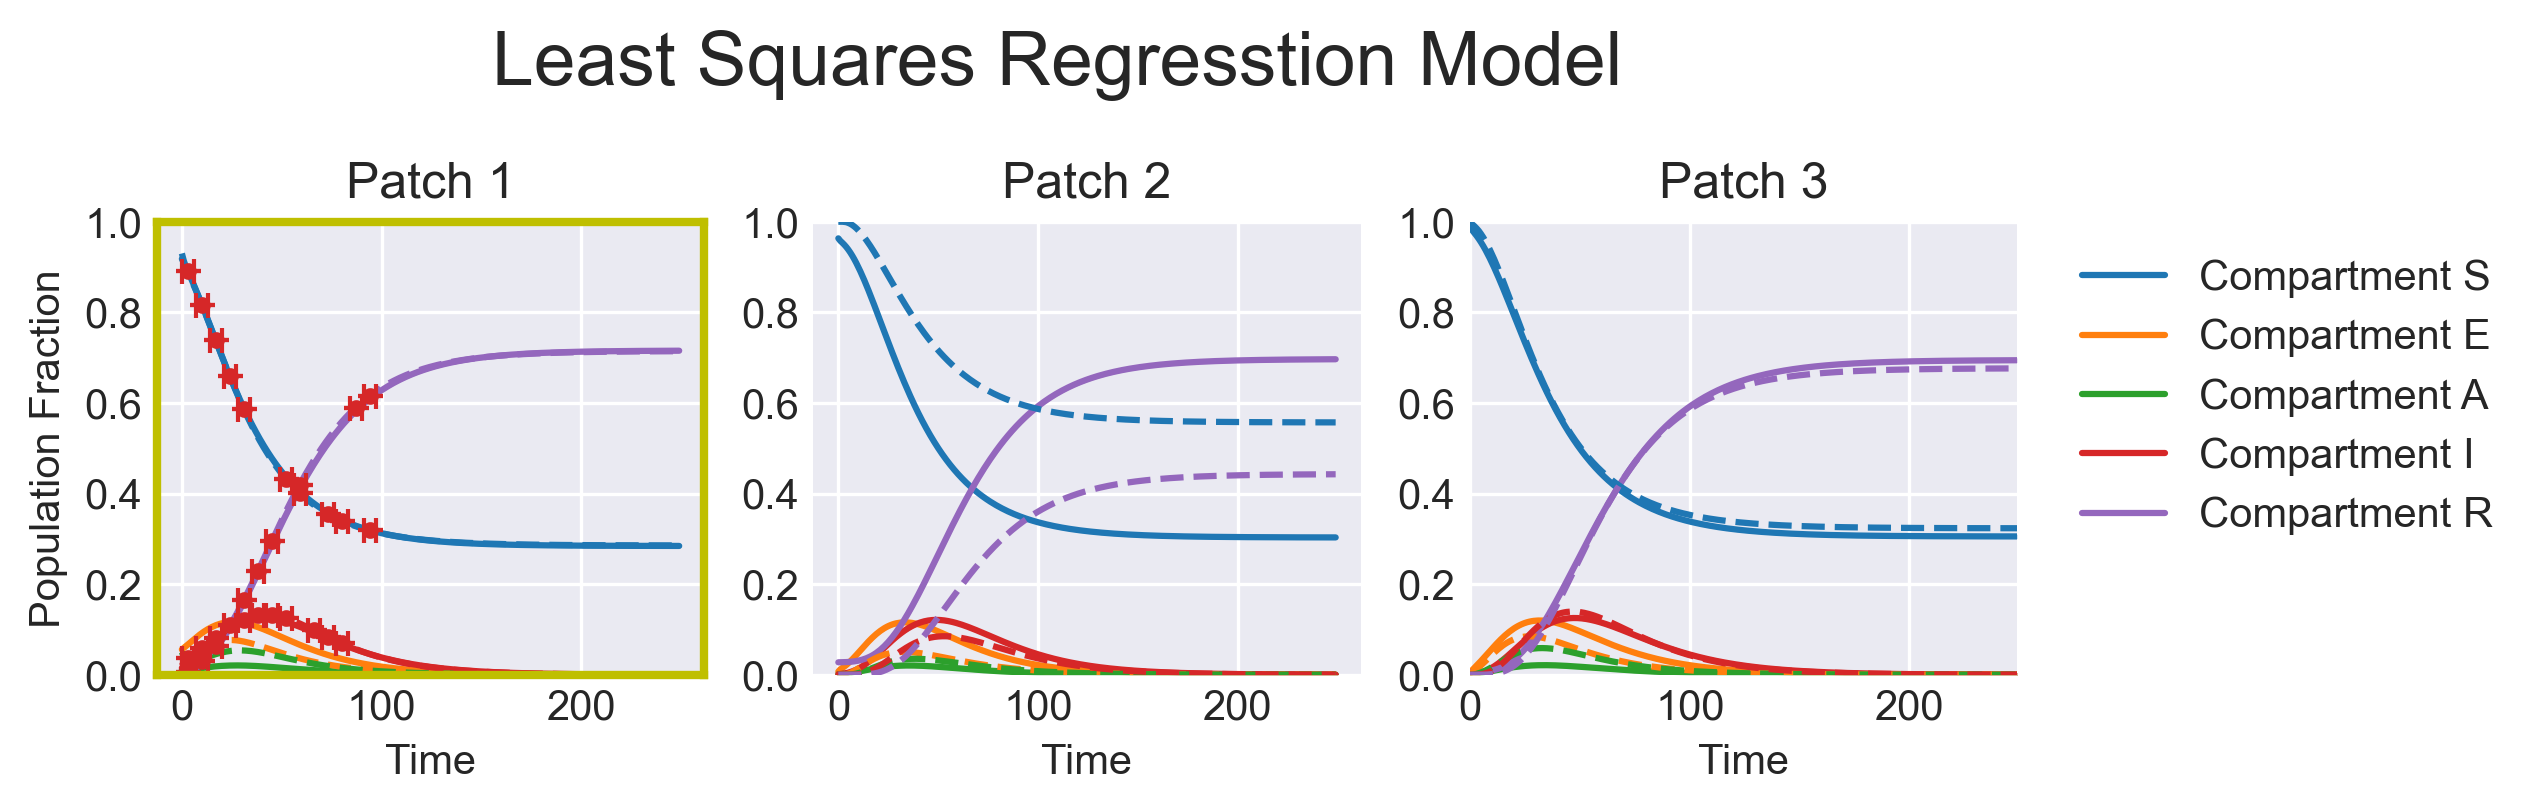

In [62]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Least Squares Regresstion Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(regressed_traj[:,:,0,:], names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(regressed_traj[:,:,1,:], names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(regressed_traj[:,:,2,:], names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
#     axs[i].plot(regressed_traj[0,:,i,:])
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()

## Hyper-biasing

In [63]:
fit_param_model = maxentep.MetaParameterJoint(np.zeros((M,)), R_norm , tmat, name='unbiased_model', hypers = hyper_pram)
fit_param_model.compile(tf.optimizers.SGD(1))
# fit_param_model.compile(tf.optimizers.Adam(0.1))

hme_model = maxentep.HyperMaxentModel(restraints, fit_param_model, model, reweight=False)
hme_model.compile(tf.keras.optimizers.SGD(learning_rate=0.1), 'mean_squared_error')

In [64]:
hme_history = hme_model.fit(
    N, final_batch_multiplier=batches, 
    outter_epochs=1, param_epochs=16, batch_size=64, epochs=1000)

Epoch 1/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0056 - weight-entropy: 4.1537
Epoch 2/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0033 - weight-entropy: 4.1288
Epoch 3/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0018 - weight-entropy: 4.0983
Epoch 4/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0015 - weight-entropy: 4.0724
Epoch 5/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 4.0556
Epoch 6/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 4.0423: 0s - loss: 0.0015 - weight-entropy: 4.
Epoch 7/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 4.0372
Epoch 8/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0320
Epoch 9/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entr

Epoch 69/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0293
Epoch 70/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.0269
Epoch 71/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0272
Epoch 72/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0279
Epoch 73/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 4.0264
Epoch 74/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0287
Epoch 75/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0269
Epoch 76/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0265
Epoch 77/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.0271
Epoch 78/1000
128/1

128/128 [==============================] - 0s 2ms/step - loss: 0.0013 - weight-entropy: 4.0286
Epoch 144/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0270
Epoch 145/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0267
Epoch 146/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0273
Epoch 147/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0014 - weight-entropy: 4.0247
Epoch 148/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0279
Epoch 149/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 4.0275
Epoch 150/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.0268
Epoch 151/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0260
Epoch 152/1000
128/128 [=

128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.0259
Epoch 218/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0246
Epoch 219/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0288
Epoch 220/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0258
Epoch 221/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0253
Epoch 222/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0251
Epoch 223/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.0260
Epoch 224/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0265
Epoch 225/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0244
Epoch 226/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 4.0261
Epoch 292/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.0255
Epoch 293/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0258
Epoch 294/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0246
Epoch 295/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0254
Epoch 296/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0251
Epoch 297/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 4.0265
Epoch 298/1000
128/128 [==============================] - 0s 2ms/step - loss: 9.9519e-04 - weight-entropy: 4.0256
Epoch 299/1000
128/128 [==============================] - 0s 1ms/step - loss: 9.6780e-04 - weight-entropy: 4.0243
Epoch 300/1000
12

128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0251
Epoch 365/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0231
Epoch 366/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0248
Epoch 367/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 4.0257
Epoch 368/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 4.0238
Epoch 369/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.0245TA: 0s - loss: 0.0011 - weight-entropy: 4.02
Epoch 370/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 4.0266
Epoch 371/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 4.0252
Epoch 372/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weig

128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0218
Epoch 437/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0240
Epoch 438/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0230
Epoch 439/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0234
Epoch 440/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.0249
Epoch 441/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0246
Epoch 442/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0256
Epoch 443/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0251
Epoch 444/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0266
Epoch 445/1000
128/128 [=

Epoch 510/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0254
Epoch 511/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0231
Epoch 512/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.0247
Epoch 513/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0238
Epoch 514/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0232
Epoch 515/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0230
Epoch 516/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 4.0237
Epoch 517/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 4.0218
Epoch 518/1000
128/128 [==============================] - 0s 2ms/step - loss: 9.8874e-04 - weight-entropy: 4.0220
Epoch 

128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0197
Epoch 583/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 4.0230
Epoch 584/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 4.0204
Epoch 585/1000
128/128 [==============================] - ETA: 0s - loss: 0.0011 - weight-entropy: 4.02 - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0224
Epoch 586/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0219
Epoch 587/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0237
Epoch 588/1000
128/128 [==============================] - 0s 1ms/step - loss: 9.8257e-04 - weight-entropy: 4.0197
Epoch 589/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 4.0218
Epoch 590/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.001

128/128 [==============================] - 0s 1ms/step - loss: 9.3975e-04 - weight-entropy: 4.0198
Epoch 655/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.0201
Epoch 656/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 4.0218
Epoch 657/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0207
Epoch 658/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0202
Epoch 659/1000
128/128 [==============================] - 0s 1ms/step - loss: 9.7712e-04 - weight-entropy: 4.0216
Epoch 660/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 4.0228
Epoch 661/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.0236
Epoch 662/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0202
Epoch 663/1000
12

128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0206
Epoch 728/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0212
Epoch 729/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 4.0195
Epoch 730/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 4.0193
Epoch 731/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 4.0202
Epoch 732/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 4.0211
Epoch 733/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0215
Epoch 734/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0215
Epoch 735/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0197
Epoch 736/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0193
Epoch 801/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0183
Epoch 802/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.0191
Epoch 803/1000
128/128 [==============================] - 0s 1ms/step - loss: 9.8446e-04 - weight-entropy: 4.0188
Epoch 804/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0185
Epoch 805/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0010 - weight-entropy: 4.0180
Epoch 806/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0196
Epoch 807/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0182
Epoch 808/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.0203
Epoch 809/1000
128/12

128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.0185
Epoch 874/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.0176
Epoch 875/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 4.0169
Epoch 876/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.0205
Epoch 877/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 4.0169
Epoch 878/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 4.0178
Epoch 879/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 4.0166
Epoch 880/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 4.0177
Epoch 881/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.0196
Epoch 882/1000
128/128 [=

128/128 [==============================] - 0s 1ms/step - loss: 9.7737e-04 - weight-entropy: 4.0160
Epoch 948/1000
128/128 [==============================] - 0s 1ms/step - loss: 9.6592e-04 - weight-entropy: 4.0164
Epoch 949/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 4.0175
Epoch 950/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0012 - weight-entropy: 4.0170
Epoch 951/1000
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.0171
Epoch 952/1000
128/128 [==============================] - 0s 1ms/step - loss: 9.7681e-04 - weight-entropy: 4.0165
Epoch 953/1000
128/128 [==============================] - 0s 1ms/step - loss: 9.8998e-04 - weight-entropy: 4.0162
Epoch 954/1000
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0175
Epoch 955/1000
128/128 [==============================] - 0s 1ms/step - loss: 9.5246e-04 - weight-entropy: 4.0176
Epoch

In [65]:
hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error') 
# hme_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), loss=ref_traj_loss)
hme_final_history = hme_model.fit(N, final_batch_multiplier=batches, outter_epochs=1, batch_size=64, epochs=200)

Epoch 1/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0015 - weight-entropy: 4.0409
Epoch 2/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 4.0294
Epoch 3/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0012 - weight-entropy: 4.0357
Epoch 4/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0358
Epoch 5/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0011 - weight-entropy: 4.0309
Epoch 6/200
128/128 [==============================] - 0s 2ms/step - loss: 0.0010 - weight-entropy: 4.0305
Epoch 7/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0011 - weight-entropy: 4.0255
Epoch 8/200
128/128 [==============================] - 0s 1ms/step - loss: 0.0013 - weight-entropy: 4.0284
Epoch 9/200
128/128 [==============================] - 0s 1ms/step - loss: 9.6766e-04 - weight-entropy: 4.0211
Epoch 10/200
128/128 [===========

128/128 [==============================] - 0s 1ms/step - loss: 8.3734e-04 - weight-entropy: 3.8416
Epoch 69/200
128/128 [==============================] - 0s 1ms/step - loss: 7.4218e-04 - weight-entropy: 3.8421
Epoch 70/200
128/128 [==============================] - 0s 2ms/step - loss: 7.4136e-04 - weight-entropy: 3.8416
Epoch 71/200
128/128 [==============================] - 0s 1ms/step - loss: 8.3100e-04 - weight-entropy: 3.8407
Epoch 72/200
128/128 [==============================] - 0s 1ms/step - loss: 6.9144e-04 - weight-entropy: 3.8398
Epoch 73/200
128/128 [==============================] - 0s 1ms/step - loss: 8.2725e-04 - weight-entropy: 3.8367
Epoch 74/200
128/128 [==============================] - 0s 1ms/step - loss: 7.9872e-04 - weight-entropy: 3.8362
Epoch 75/200
128/128 [==============================] - 0s 1ms/step - loss: 7.8818e-04 - weight-entropy: 3.8393
Epoch 76/200
128/128 [==============================] - 0s 2ms/step - loss: 7.1131e-04 - weight-entropy: 3.8367
Epoch

128/128 [==============================] - 0s 1ms/step - loss: 7.0253e-04 - weight-entropy: 3.7884
Epoch 141/200
128/128 [==============================] - 0s 2ms/step - loss: 6.7162e-04 - weight-entropy: 3.7850
Epoch 142/200
128/128 [==============================] - 0s 1ms/step - loss: 5.9106e-04 - weight-entropy: 3.7835
Epoch 143/200
128/128 [==============================] - 0s 1ms/step - loss: 7.5689e-04 - weight-entropy: 3.7886
Epoch 144/200
128/128 [==============================] - 0s 1ms/step - loss: 6.5341e-04 - weight-entropy: 3.7880
Epoch 145/200
128/128 [==============================] - 0s 1ms/step - loss: 6.6647e-04 - weight-entropy: 3.7852
Epoch 146/200
128/128 [==============================] - 0s 1ms/step - loss: 5.9867e-04 - weight-entropy: 3.7828
Epoch 147/200
128/128 [==============================] - 0s 2ms/step - loss: 7.1174e-04 - weight-entropy: 3.7831
Epoch 148/200
128/128 [==============================] - 0s 1ms/step - loss: 8.1187e-04 - weight-entropy: 3.78

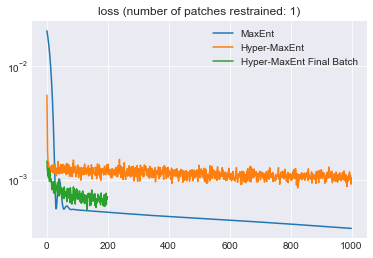

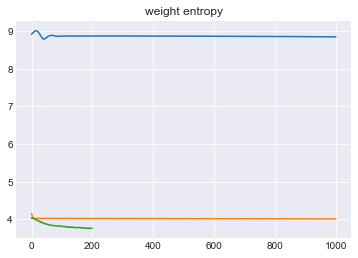

In [66]:
plt.plot(me_history.history['loss'],label='MaxEnt')
plt.plot(hme_history.history['loss'],label='Hyper-MaxEnt')
plt.plot(hme_final_history.history['loss'],label='Hyper-MaxEnt Final Batch')
plt.title('loss (number of patches restrained: {})'.format(len(restrained_patches)))
plt.yscale('log')
plt.legend()
# plt.savefig('loss_{}_restraints'.format(len(restrained_patches)),dpi= 300)
plt.show()

plt.plot(me_history.history['weight-entropy'])
plt.plot(hme_history.history['weight-entropy'])
plt.plot(hme_final_history.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

# plt.plot(hme_history.history['prior-loss'])
# plt.title('neg log-likelihood')
# plt.show()

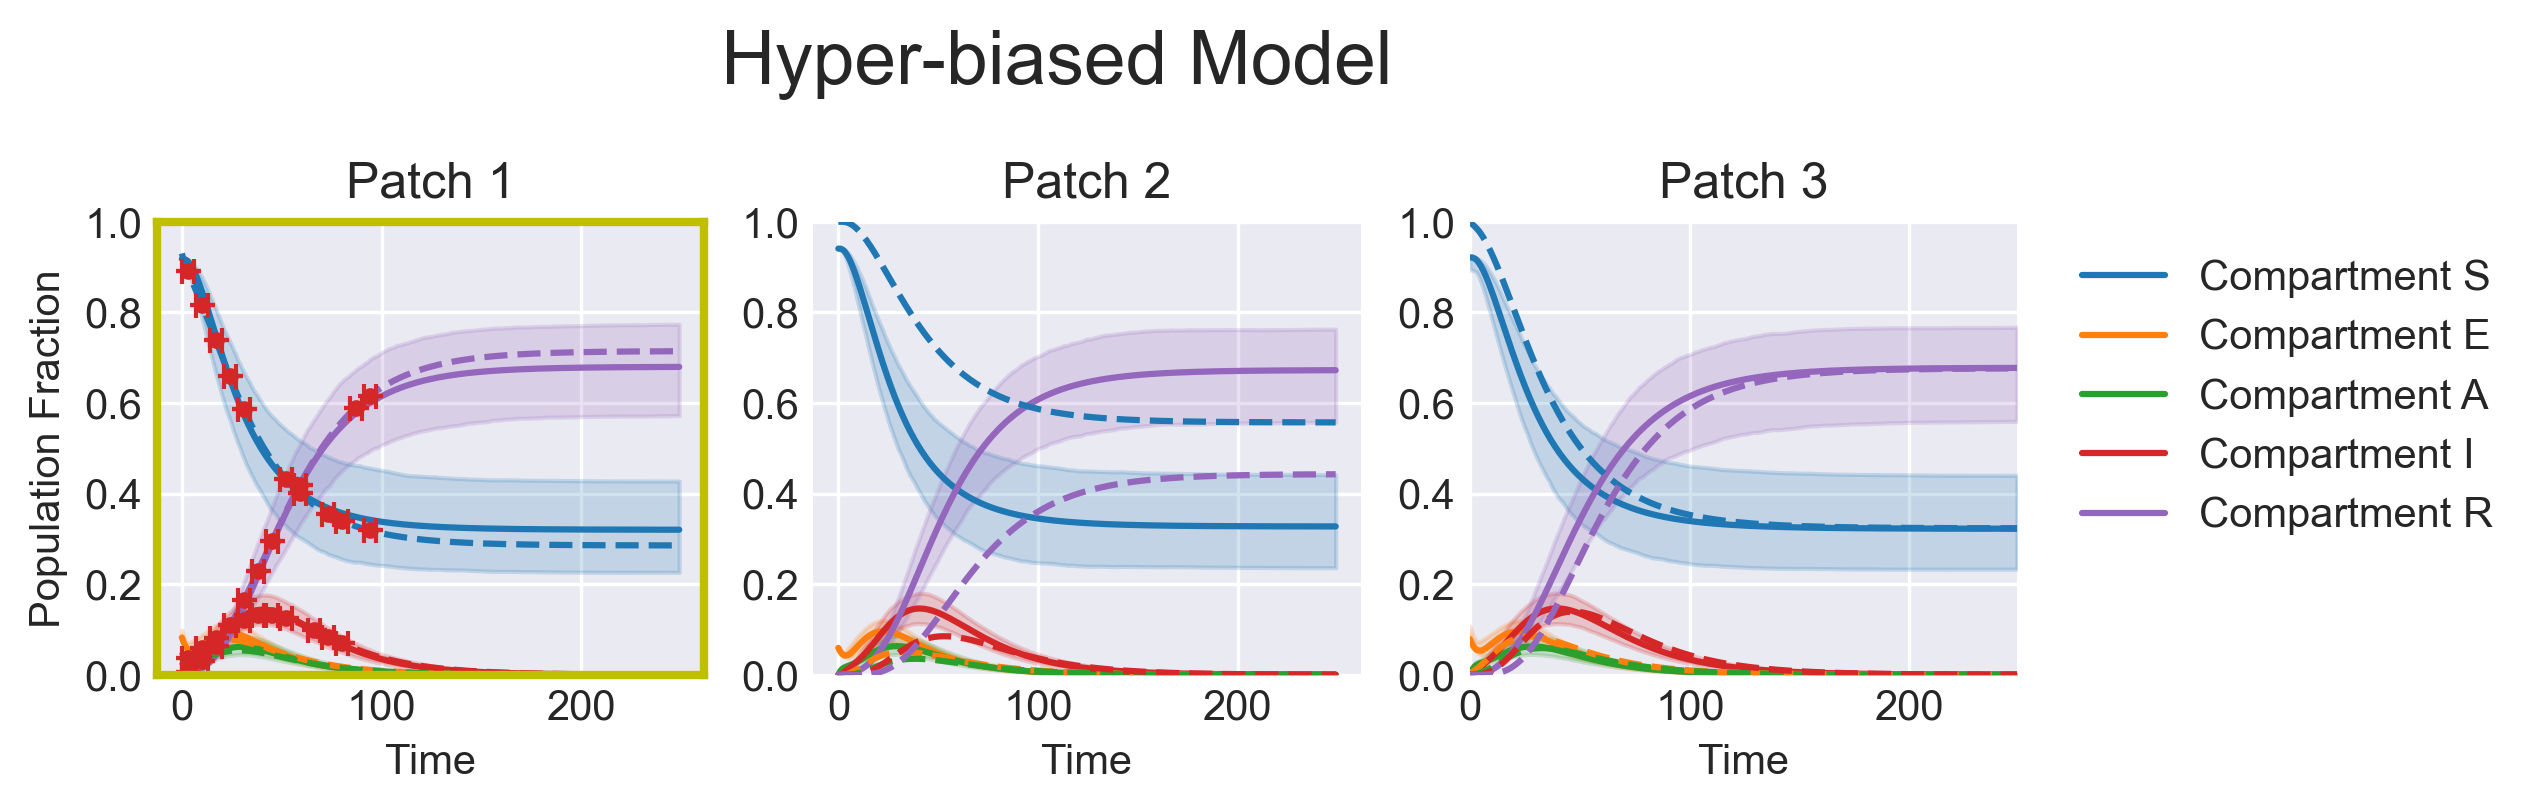

In [67]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Hyper-biased Model', y = 1.2, fontsize = 18)
maxentep.traj_quantile(hme_model.trajs[:,:,0,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[0], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(hme_model.trajs[:,:,1,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[1], add_legend= False, alpha = 0.2)
maxentep.traj_quantile(hme_model.trajs[:,:,2,:], weights=hme_model.traj_weights, names=full_compartments, plot_means=True, ax =axs[2], alpha = 0.2)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1.0])
    axs[i].plot(ref_traj[:,i],linestyle='--')
    if i in restrained_patches:
        for _,pf in enumerate(plot_fxns_list[restrained_patches.tolist().index(i)]):
                pf(axs[i],0, color='C3')
        axs[i].spines['bottom'].set_color('y')
        axs[i].spines['top'].set_color('y') 
        axs[i].spines['right'].set_color('y')
        axs[i].spines['left'].set_color('y')
        axs[i].spines['left'].set_linewidth(2)
        axs[i].spines['top'].set_linewidth(2)
        axs[i].spines['right'].set_linewidth(2)
        axs[i].spines['bottom'].set_linewidth(2)
axs[0].set_ylabel('Population Fraction')
plt.show()